In [1]:
import os

import librosa                                       # 음성 분석을 위함
import numpy as np                                      

import soundfile as sf

import tensorflow as tf
import tensorflow_hub as hub
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from pydub import AudioSegment                       # 오디오를 자르기 위함

import matplotlib.pyplot as plt                      # 그래프를 그리기 위함
from IPython.display import Audio                    # GUI 형태로 오디오 파일 재생을 위함

from scipy.interpolate import interp1d

model = hub.load("https://tfhub.dev/google/spice/2") # SPICE 모델 로드

1. 음정 주파수 배열 추출 함수 정의

In [13]:
def extract_pitches(audio_path, duration):

        original_y, sr = librosa.load(audio_path, mono=True, duration=duration)                     # SPICE모델은 mono 타입의 오디오만 지원

        MAX_ABS_INT16 = 32768.0                                                                     # 16비트 PCM 형식에서 가능한 최대 절댓값을 나타내는 상수

        y = original_y/float(MAX_ABS_INT16)                                                         # -1과 1사이의 부동 소수점으로 정규화

        model_output = model.signatures["serving_default"](tf.constant(y, tf.float32))              # 음정과 신뢰도를 얻음

        pitch_outputs = model_output["pitch"].numpy()                                               # 음정만 추출
        
        original_duration = len(y) / sr                                                             # 원래 신호의 전체 시간 (초)

        pitch_time = np.linspace(0, original_duration, len(pitch_outputs))                          # 음정 출력의 시간 축 생성 (초 단위)
        resampled_time = np.linspace(0, original_duration, int(original_duration))                  # 원곡 시간 축 생성 (초 단위)

        interp_func = interp1d(pitch_time, pitch_outputs, kind='linear', fill_value="extrapolate")  # 보간 함수 생성
        
        resampled_pitch_outputs = interp_func(resampled_time)                                       # 보간법 적용하여 음정 출력을 원래 신호의 길이에 맞춤

        file_path = audio_path.replace('.wav', '.npy')                                              # 오디오 파일명과 같은 이름으로 npy 파일 생성

        np.save(file_path, resampled_pitch_outputs)                                                 # 오디오 배열 저장

        return pitch_outputs, resampled_pitch_outputs, original_y, sr

In [14]:
audio_name = '장범준-흔들리는 꽃들 속에서 네 샴푸향이 느껴진거야'
artist_audio_path = f'assets/audio/artist/{audio_name}'         # 원곡 음원 경로
user_audio_path = f'assets/audio/user/{audio_name}'             # 커버 음원 경로

# user_audio_path = 'user_recording'   # 커버 음원 경로

y, sr =  librosa.load(f'{artist_audio_path}.wav', mono=True)
duration = round(len(y)/sr, 1)

artist_audio, resampled_artist_audio, _, _ = extract_pitches(f'{artist_audio_path}.wav', duration)
user_audio, resampled_user_audio, _, _ = extract_pitches(f'{user_audio_path}.wav', duration)

In [20]:
audio_name = '정준일-안아줘'
user_audio_path = f'assets/audio/user/{audio_name}'             # 커버 음원 경로
user_audio, resampled_user_audio, _, _ = extract_pitches(f'{user_audio_path}.wav', duration)

C:\Users\rnehd\AppData\Local\Temp\ipykernel_39660\3198402827.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  original_y, sr = librosa.load(audio_path, mono=True, duration=duration)                     # SPICE모델은 mono 타입의 오디오만 지원
c:\Users\rnehd\.conda\envs\singking\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [19]:
len(artist_audio)

1659

In [21]:
len(user_audio)

1659

2. 음정 주파수 배열 비교

In [17]:
original = np.load(f'{artist_audio_path}.npy') # 원곡 음정 주파수 배열
cover = np.load(f'{user_audio_path}.npy')      # 사용자 음정 주파수 배열


diff = original - cover                        # 원곡 목소리와 사용자 음정 주파수 오차 계산

threshold = 0.03                               # 오차 인정 범위

# 음정 차이에 따른 평가
result = np.where(abs(diff) <= threshold, "Good", 
                    np.where(diff > threshold, "lower", 
                            np.where(diff < -threshold, "higher", None)))

score_good = round((np.sum(result=='Good') / len(result)) *100, 2) 

ValueError: operands could not be broadcast together with shapes (848927,) (848925,) 

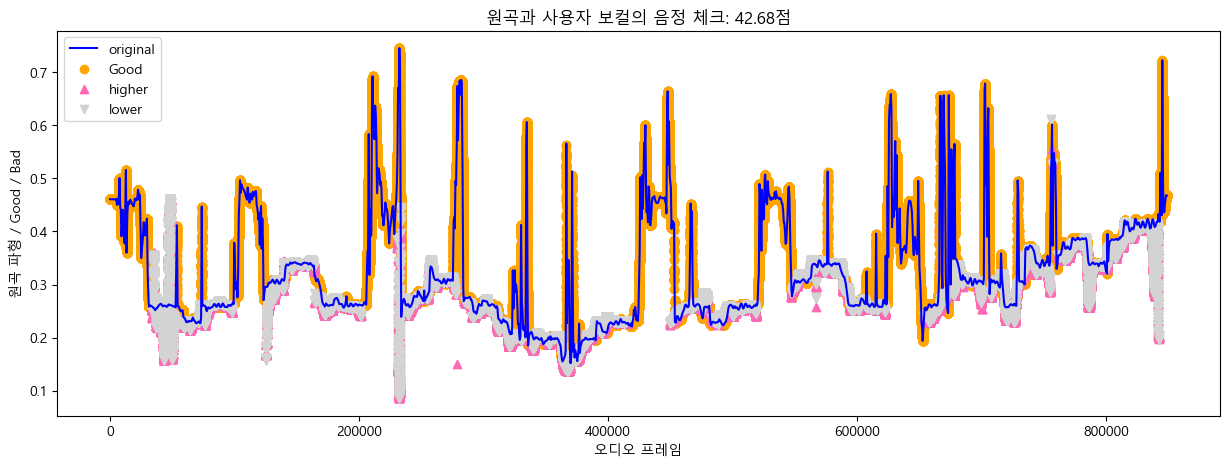

In [18]:
plt.rcParams['font.family'] = 'Malgun Gothic' # 한국어 폰트 설정

good_indices = np.where(result == 'Good')[0] # 배열이 Good인 위치 찾기 
higher_indices = np.where(result == 'higher')[0] # 배열이 high인 위치 찾기 
lower_indices = np.where(result == 'lower')[0] # 배열이 high인 위치 찾기 

plt.figure(figsize=(15, 5)) # 그래프 크기 설정 그리기

plt.plot(original, label='original', color='blue') # 원곡 음성

#plt.plot(cover, label='cover', color='orange') # 사용자 입력 음성


plt.scatter(good_indices, original[good_indices], color='orange', label='Good') # 음정 Good

plt.scatter(higher_indices, cover[higher_indices], color='hotpink', label='higher', marker="^") # 음정 높음

plt.scatter(lower_indices, cover[lower_indices], color='lightgrey', label='lower', marker="v") # 음정 낮음


plt.title(f'원곡과 사용자 보컬의 음정 체크: {score_good}점')
plt.xlabel('오디오 프레임')
plt.ylabel('원곡 파형 / Good / Bad')
plt.legend()

# 그래프 표시
plt.show()

틀린 구간 초(시작, 끝): [(0, 9), (11, 17)]


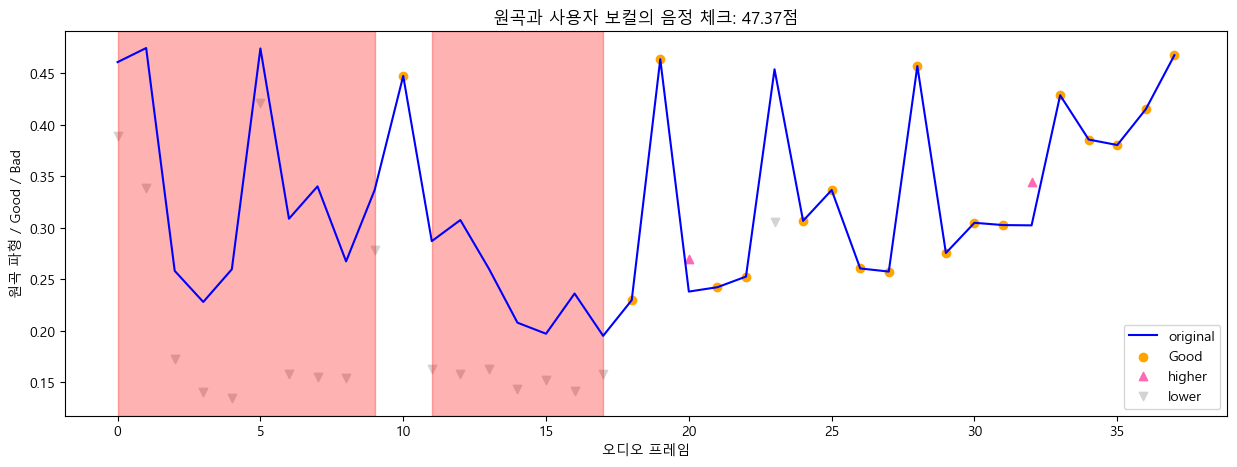

In [20]:
plt.rcParams['font.family'] = 'Malgun Gothic'           # 한국어 폰트 설정

good_indices = np.where(result == 'Good')[0]            # 배열이 Good인 위치 찾기 
higher_indices = np.where(result == 'higher')[0]        # 배열이 higher인 위치 찾기 
lower_indices = np.where(result == 'lower')[0]          # 배열이 lower인 위치 찾기 

def find_wrong_segments(result):                        # 틀린 구간 시작점과 끝점 찾는 함수 (2초를 초과하여 틀렸을 경우만)
    wrong_segments = []
    in_wrong_segment = False
    start_idx = None

    for i in range(len(result)):
        if result[i] != 'Good':
            if not in_wrong_segment:
                start_idx = i
                in_wrong_segment = True
        else:
            if in_wrong_segment:
                end_idx = i - 1
                # 틀린 구간의 길이가 1초 초과인지 확인
                if (end_idx - start_idx) > 2:
                    wrong_segments.append((start_idx, end_idx))
                in_wrong_segment = False

    # 마지막 구간이 틀린 구간으로 끝나는 경우
    if in_wrong_segment:
        end_idx = len(result) - 1
        if (end_idx - start_idx) > 1:
            wrong_segments.append((start_idx, end_idx))
    return wrong_segments

wrong_segments = find_wrong_segments(result) 
print("틀린 구간 초(시작, 끝):", wrong_segments)

plt.figure(figsize=(15, 5))                             # 그래프 크기 설정 그리기

plt.plot(original, label='original', color='blue')      # 원곡 음성
# plt.plot(cover, label='cover', color='orange')        # 사용자 입력 음성

plt.scatter(good_indices, original[good_indices], color='orange', label='Good')                  # 음정 맞음
plt.scatter(higher_indices, cover[higher_indices], color='hotpink', label='higher', marker="^")  # 음정 높음
plt.scatter(lower_indices, cover[lower_indices], color='lightgrey', label='lower', marker="v")   # 음정 낮음

# 틀린 구간 강조 표시
for start, end in wrong_segments:
    plt.axvspan(start, end, color='red', alpha=0.3)

plt.title(f'원곡과 사용자 보컬의 음정 체크: {score_good}점')
plt.xlabel('오디오 프레임')
plt.ylabel('원곡 파형 / Good / Bad')
plt.legend()

# 그래프 표시
plt.show()

# 틀린 구간의 오디오 저장
for index, s in enumerate(wrong_segments):
    audio_segment = artist_audio[s[0]*sr:(s[1]+1)*sr]
    
    sf.write(f'{artist_audio_path}_segment{index+1}.wav', audio_segment, sr)

In [21]:
from modules.lyrics_find import find_incorrect

incorrect_data = []

for file in os.listdir('artist_audio'):
    if 'segment' in file:
        song_name = file.split('_')[0]          # 노래 이름 추출
        print(file)
        incorrect = find_incorrect(f'artist_audio/{file}', f'lyrics/{song_name}.txt')
        incorrect_data.append(incorrect)

flower_segment1.wav
0 0.6373626373626373
1 0.6808510638297872
flower_segment2.wav
3 0.8524590163934426


In [22]:
incorrect_data

[(['흔들리는 꽃들 속에서', '네 샴푸향이 느껴진거야'], [0.6373626373626373, 0.6808510638297872]),
 (['그냥 사람들만 보이는거야'], [0.8524590163934426])]